# A6 Customer Segmentation

**Rationale** The idea for this assignment is to give you hands on experience in applying behavioral segmentation techniques to real world data where the variables you use for segmentation are not already created for you (you must define them first). Thus you must first do "feature engineering" before you can do segmentation. Don't worry, this problem is broken down into components.

The dataset we use is a retail invoice. Each invoice is one purchase occassion, and for each invoice we have several observations representing the unique items (stockcode) purchased on that occassion.

The goal of the first part is to create useful features about each consumer's observed behaviors, i.e. go from transaction level to customer level data. The goal of the second part is to then do behavioral segmentation based on these newly constructed features.

# Part 1 Feature Engineering (25 points)

Generally, feature engineering is where your marketing domain knowledge comes into play. In other words, your intuitions about what matters in terms of separating consumers into different groups should drive what features (aka variables/columns) to create. However, in this assignment, you are expected to compute the characteristics detailed in the following instructions.


Read in the data, preview it, and familiarize yourself with the contents of the data.

In [ ]:
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
drive.mount('drive', force_remount=True)

Mounted at drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fpath = '/content/drive/MyDrive/Colab Notebooks/'
os.listdir(fpath)

['avocado.csv',
 'Assignment 1',
 'Assignment2Dotsenko"A2 - programming fundamentals.ipynb"',
 '.ipynb_checkpoints',
 'quebec_biz.csv',
 'quebec_yelp_reviews.csv',
 'filtered_quebec_yelp_reviews.csv',
 'facebook_ads.csv',
 'starbucks_promos.csv',
 'Копия блокнота "A3_Yelp_Reviews.ipynb"',
 'Копия блокнота "A4 Stats Review.ipynb"',
 'Копия блокнота "A5 Regression.ipynb"',
 'online_invoices.csv']

In [ ]:
data = pd.read_csv(fpath + 'online_invoices.csv', index_col = 0)


In [ ]:
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Answer questions here**

What does each row represent? C (pick one)

A. 1 invoice (1 point of sale transaction) \\
B. A single item sold \\
C. Each unique item sold in a transaction \\
D. Daily sales \\
E. 1 customer's total purchases on each day



## Unique count variables

Create a dataframe, `df_u` that represents each consumer's total number of transactions and unique products purchased.

Hint: use a `groupby` + `.nunique()` statement. `df.groupby('id')[['var1', 'var2',....]].nunique().reset_index()` will compute the number of unique values of columns 'var1', 'var2',.... for each "id". You should calculate the number of unique `StockCode`'s (like SKU's) and `InvoicesNo`'s for each `CustomerID`. Change your column names in the resulting dataframe, `df_u`, to `['CustomerID', 'NProducts', 'NTrans']`.

In [ ]:
df_u = data.groupby('CustomerID')[['InvoiceNo', 'StockCode']].nunique().reset_index()
df_u.columns = ['CustomerID', 'NTrans', 'NProducts']

df_u.head()


,CustomerID,NTrans,NProducts
0,12346.0,1,1
1,12347.0,7,103
2,12348.0,4,21
3,12349.0,1,72
4,12350.0,1,16



## Customer spend

Compute the total customer spending and number of units purchased for each customer of this retailer.

Hint
1. Create a column for `TotalSpend` (unit price x quantity)
1. Use a (groupby + sum) to create a dataframe `df_s` that contains each customer's sum of `TotalSpend` and `Quantity`
1. rename the quantity column to `TotalUnits`


In [ ]:
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']
df_s = data.groupby('CustomerID')[['TotalSpend', 'Quantity']].sum().reset_index()
df_s.columns = ['CustomerID', 'TotalSpend', 'TotalUnits']

df_s.head()


,CustomerID,TotalSpend,TotalUnits
0,12346.0,77183.60,74215
1,12347.0,4310.00,2458
2,12348.0,1437.24,2332
3,12349.0,1457.55,630
4,12350.0,294.40,196



## Compute price of average SKU purchased

Compute and create the `AveragePrice` column using the `df_s` dataframe's `TotalSpend` and `TotalUnits`.


In [ ]:
df_s['AveragePrice'] = df_s['TotalSpend'] / df_s['TotalUnits']

df_s.head()


,CustomerID,TotalSpend,TotalUnits,AveragePrice
0,12346.0,77183.60,74215,1.040000
1,12347.0,4310.00,2458,1.753458
2,12348.0,1437.24,2332,0.616312
3,12349.0,1457.55,630,2.313571
4,12350.0,294.40,196,1.502041



## Merge `df_u` and `df_s`, call new dataframe df_c (c for "consumer")

Using the variables in `df_c`, compute the following additional column:
1. Spend per transaction (call it "SpendPerTrans")

In total, you should have `df_c` with columns `['CustomerID', 'NTrans', 'NProducts', 'TotalSpend', 'AveragePrice', 'SpendPerTrans']`


**Answer this**

On what column should you merge `df_s` and `df_u`?

* Answer: CustomerID

In [ ]:
df_c = pd.merge(df_u, df_s, on='CustomerID', how='outer')

df_c['SpendPerTrans'] = df_c['TotalSpend'] / df_c['NTrans']

df_c.head()


,CustomerID,NTrans,NProducts,TotalSpend,TotalUnits,AveragePrice,SpendPerTrans
0,12346.0,1,1,77183.60,74215,1.040000,77183.600000
1,12347.0,7,103,4310.00,2458,1.753458,615.714286
2,12348.0,4,21,1437.24,2332,0.616312,359.310000
3,12349.0,1,72,1457.55,630,2.313571,1457.550000
4,12350.0,1,16,294.40,196,1.502041,294.400000


## Log transformation

1. Plot the histogram of all the variables of df_c other than CustomerID
1. Replace each of these variables with their respective log transformations
1. Plot the histograms again, what's different?

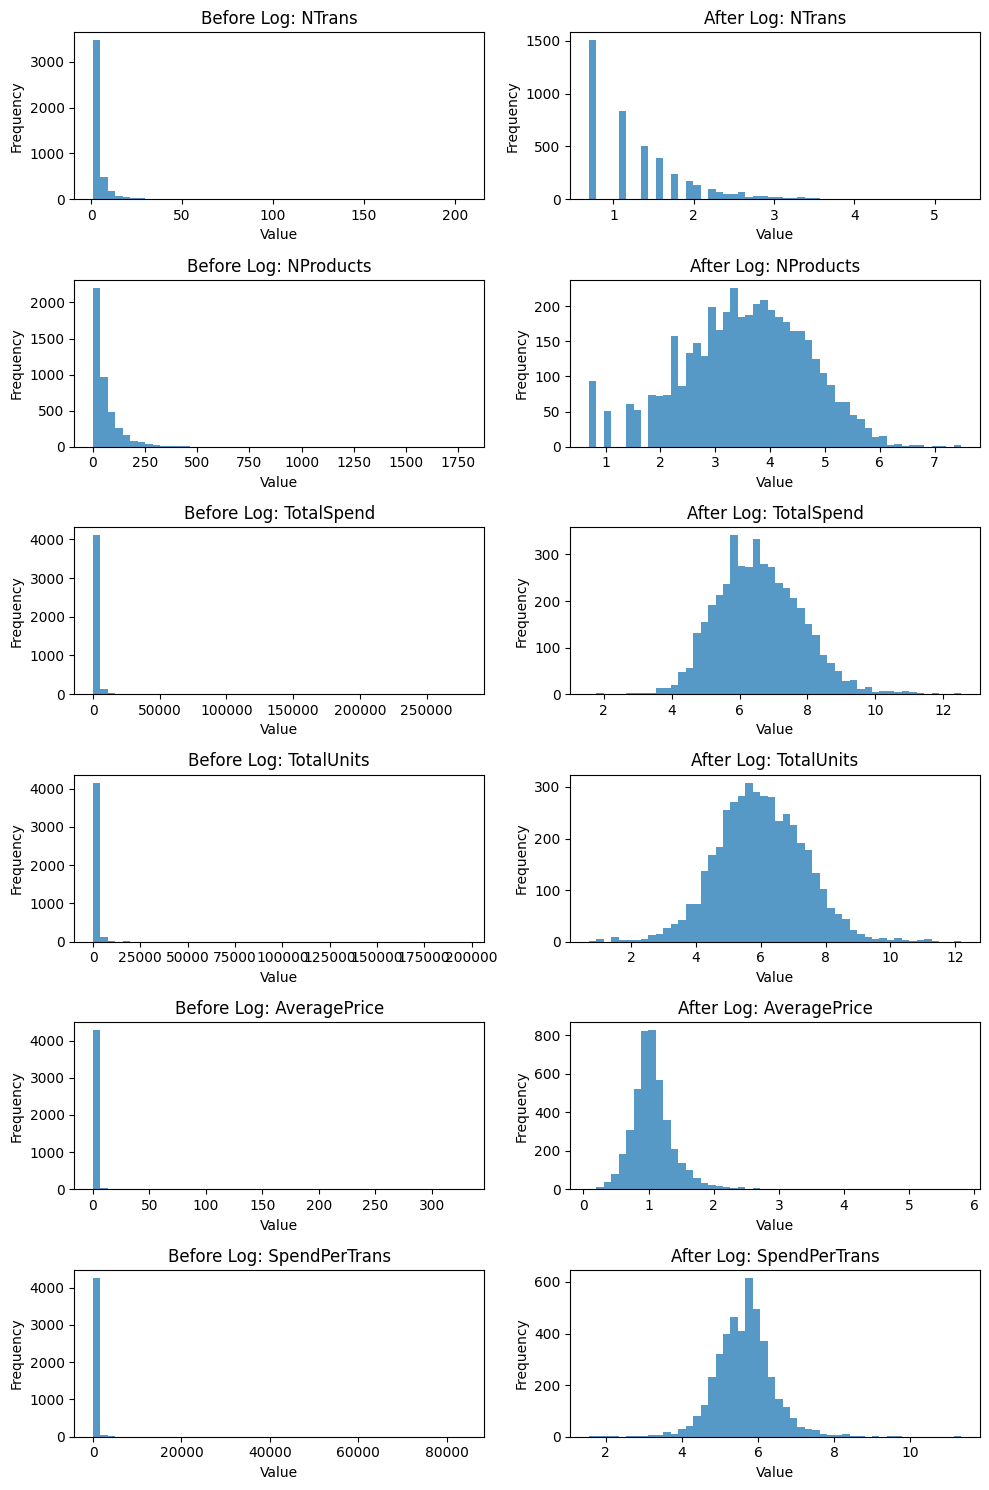

In [ ]:
log_columns = ['NTrans', 'NProducts', 'TotalSpend', 'TotalUnits', 'AveragePrice', 'SpendPerTrans']
df_c_log = df_c.copy()
for col in log_columns:
    df_c_log[col] = np.log1p(df_c_log[col])  # используем log1p для избежания проблем с логарифмом нуля

hist_data = {'Before Log': df_c, 'After Log': df_c_log}
fig, axes = plt.subplots(len(log_columns), 2, figsize=(10, 15))
for i, col in enumerate(log_columns):
    for j, (title, data) in enumerate(hist_data.items()):
        axes[i, j].hist(data[col], bins=50, alpha=0.75)
        axes[i, j].set_title(f"{title}: {col}")
        axes[i, j].set_xlabel('Value')
        axes[i, j].set_ylabel('Frequency')
plt.tight_layout()


**Answer this**

Why might you want to transform these variables by taking logs of each of these variables? (Notice the difference after taking the log transformation)

* Answer:

Normality: Log transformation can help in stabilizing the variance across data and making it more normally distributed, which is an assumption of many statistical techniques.


Handling Skewness: Many algorithms work better if the variables are normally distributed. Log transformation is particularly effective when dealing with right-skewed data (where the tail on the right side is longer or fatter than the left side).


Multiplicative to Additive: Log transformation turns multiplicative relationships into additive ones, which can simplify the modeling of complex relationships.


Reducing Scale: It can also help in reducing the scale of the variables, so that very large values do not unduly influence the results.


Improving Interpretation: In some contexts, such as financial data, log-transformed data can be more interpretable (e.g., percentage changes in log returns).


Distance Metrics: For clustering, when using distance-based metrics, transforming data using logs ensures that a few extreme values do not dominate the distance calculations.


# Create standardized version of df_c

1. Create `df_c_std` that has all the columns of `df_c` except `CustomerID`.
1. Write a loop through all the columns of `df_c_std` to standardize each column (compute the z-score by subtracting mean and dividing by standard deviation).


In [ ]:
df_c_std = df_c_log[log_columns].apply(lambda x: (x - x.mean()) / x.std())

df_c_std.head()


,NTrans,NProducts,TotalSpend,TotalUnits,AveragePrice,SpendPerTrans
0,-0.951171,-2.522554,3.726228,3.836209,-0.986599,7.553391
1,1.082166,0.966790,1.425905,1.334894,-0.140799,1.051399
2,0.392792,-0.404972,0.550635,1.296280,-1.643149,0.327845
3,-0.951171,0.654233,0.561815,0.336340,0.381415,2.210278
4,-0.951171,-0.632661,-0.711417,-0.518251,-0.410835,0.060425


**Answer question**

Why is it important to standardize variables before performing clustering?

* Answer:

Standardizing variables before performing clustering is important because it puts all variables on the same scale. This is crucial because clustering algorithms like K-Means use distance metrics (such as Euclidean distance) to determine the similarity between data points. If variables are on different scales, those with larger ranges could unduly influence the distance calculations, skewing the results. Standardization ensures that each variable contributes equally to the distance computations, allowing for a more accurate and meaningful clustering analysis.







# Part 2 Segmentation (25 points)



## Dimensionality reduction

1. Compute the 2D principal components transformation of `df_c_std`, call this `transformed`
1. Make sure `transformed` is a dataframe, then name the columns 'pc1' and 'pc2' for principal component 1 and 2, respectively.
1. Add `pc1` and `pc2` to the df_c dataframe (create the same 2 columns in df_c).

Create a scatter plot of the principal components 1 vs 2.


**Answer question**

Why might you want to reduce the dimensionality of your data (using PCA) before performing clustering?

* Answer:

Noise Reduction: PCA can help to emphasize variation and bring out strong patterns in the dataset, which often improves the quality of the clustering by reducing the noise and simplifying the dataset.


Computational Efficiency: Clustering algorithms can be computationally expensive, especially with high-dimensional data. PCA can reduce the dimensions while retaining most of the variance, leading to faster computations.


Avoiding the Curse of Dimensionality: In high-dimensional spaces, data can become sparse, and distance measures lose their meaning, which can lead to poor clustering performance. Reducing dimensions can mitigate this effect.


Interpretability: With fewer dimensions, it's often easier to visualize and interpret the results of the clustering.


Emphasizing Important Features: PCA selects the directions that maximize variance, which often correspond to the underlying structure in the data, thus potentially leading to more meaningful clusters.







In [ ]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(df_c_std)

transformed_df = pd.DataFrame(transformed, columns=['pc1', 'pc2'])

df_c['pc1'] = transformed_df['pc1']
df_c['pc2'] = transformed_df['pc2']

df_c[['CustomerID', 'pc1', 'pc2']].head()


,CustomerID,pc1,pc2
0,12346.0,5.107190,1.157967
1,12347.0,2.635878,0.263675
2,12348.0,1.261833,-1.461400
3,12349.0,1.049587,0.810112
4,12350.0,-1.206576,-0.492479


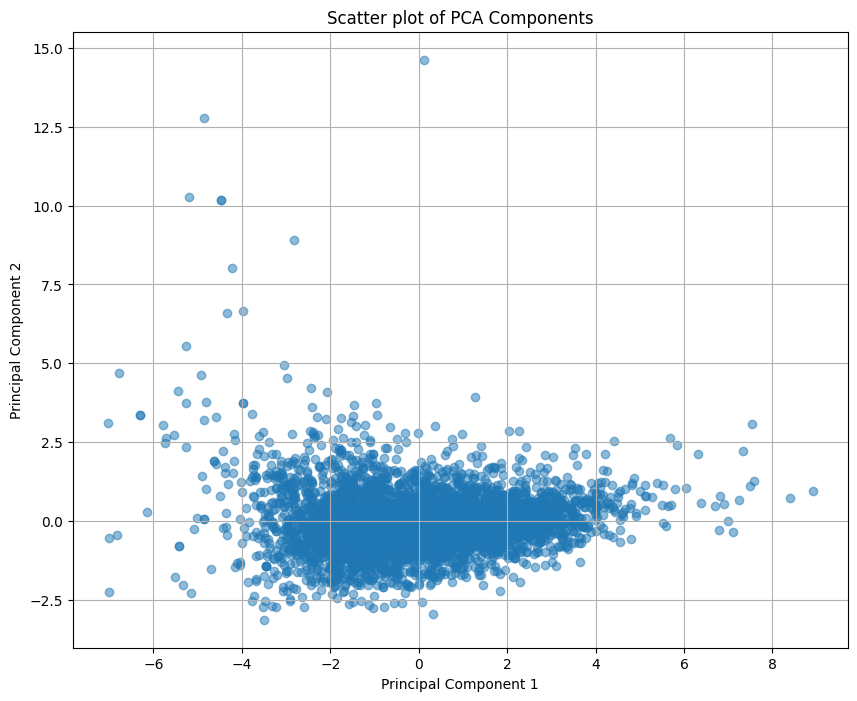

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df_c['pc1'], df_c['pc2'], alpha=0.5)
plt.title('Scatter plot of PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()



## Segmentation
Using a loop, compute the k-means clustering for $k$ from 2 to 10 segments using the `transformed` dataframe. Store the segment as the column `'seg2'`,`'seg3'`,...,`'seg10'` in the `df_c` dataframe. Make sure you store the inertia metrics in a list called `elbowdata` like in the notes. Create the elbow plot for your k-means clustering.

1. How many segments does there appear to be based on the elbow plot?
1. Use a loop to plot pc1 vs pc2 for each segment (different color for each segment)
1. Use a groupby statement to show the mean of the variables in the raw versions (not z-scores) used to conduct the segmentation. e.g. what are the averages of `['NTrans', 'NProducts', 'TotalSpend', 'AveragePrice', 'SpendPerTrans']`

1. In a few sentences, describe what are the characteristics of the resulting segments. Any distinctive segments?

**Hints**
1. Note here that `k` should be the number of clusters at each iteration of your loop, e.g. `for k in ....`
2. `df_c['seg{}'.format(k)]=` your k-means segmentation to create the `'seg2'`, ..., `'seg15'` columns.

In [ ]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed_df)
    inertia.append(kmeans.inertia_)
    df_c['seg' + str(k)] = kmeans.labels_



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

**Answer this**
What does each of the segk (for k =1,...,10) columns represent?

1. Answer:

Each of the segk columns (for k = 2, ..., 10) represents the segmentation of the dataset into k clusters. Specifically, each segk column assigns every customer to one of k segments or clusters identified by the K-Means clustering algorithm. The clusters are formed based on similarities in customer behavior characteristics derived from the data, with the goal of grouping customers with similar attributes into the same cluster.








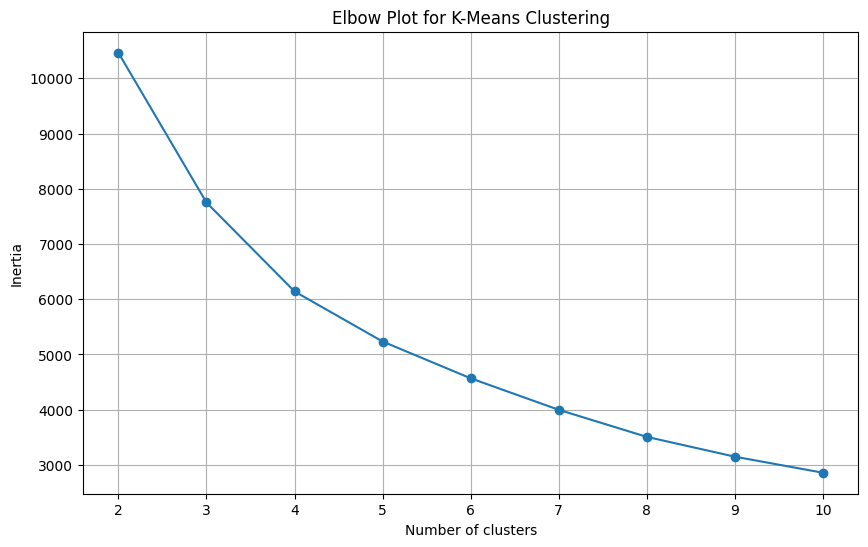

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Plot for K-Means Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()



**Answer this**
Based on the eyeball test, where is the "elbow"? i.e. how many clusters seems the "right" number
1. Answer: 4

## Inspect segments

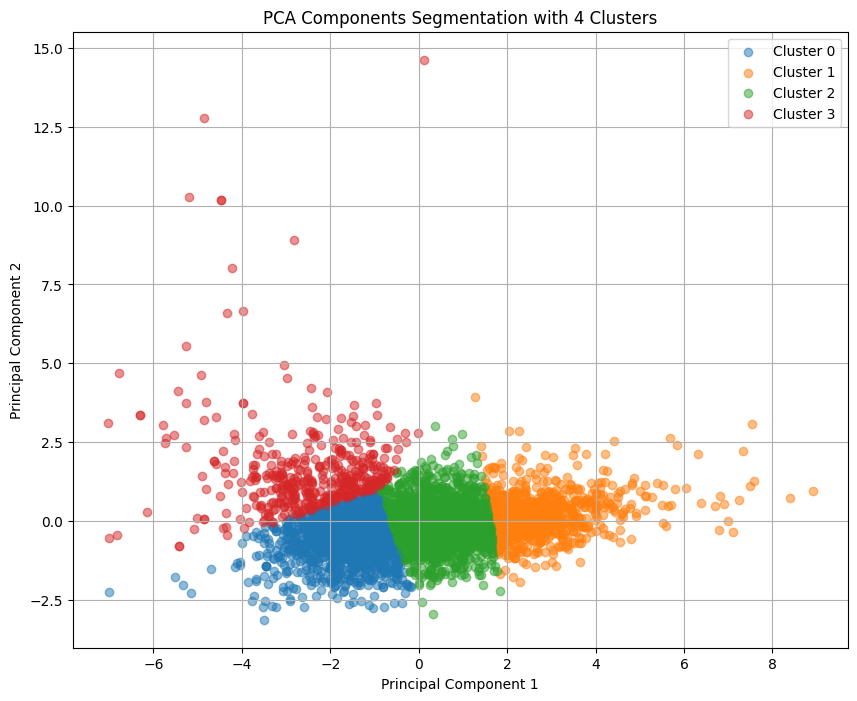

In [ ]:
optimal_k = 4

plt.figure(figsize=(10, 8))
for k in range(optimal_k):
    cluster_data = df_c[df_c['seg' + str(optimal_k)] == k]
    plt.scatter(cluster_data['pc1'], cluster_data['pc2'], alpha=0.5, label=f'Cluster {k}')

plt.title(f'PCA Components Segmentation with {optimal_k} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


Compute the average of:
```
NTrans	NProducts	TotalSpend	TotalUnits	AveragePrice SpendPerTrans
```
For each segment of the optimal KMeans segmentation (optimal being the k you found above in elbow plot).

Since these variables in df_c have been log-transformed, use np.exp(the appropriate groupby + mean statement) to take the exponent of the resulting means, i.e. "undo" the log-transformation.

e.g. np.exp(df.groupby('grpvar')[['var1', 'var2','var3',...,etc.]].mean())

In [ ]:
segment_means = np.exp(df_c.groupby('seg' + str(optimal_k))[log_columns].mean())

segment_means



/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,NTrans,NProducts,TotalSpend,TotalUnits,AveragePrice,SpendPerTrans
seg4,,,,,,
0,4.195586,3.912501e+08,2.136561e+114,4.902673e+79,5.172707,9.067242e+88
1,113539.747959,9.112043e+67,inf,inf,6.135781,inf
2,28.524513,1.402741e+25,inf,4.678226e+280,6.301795,1.045689e+175
3,4.450239,8.278016e+04,2.988929e+173,3.429129e+30,1399.714274,2.859442e+109


In [ ]:
segment_log_means = df_c.groupby('seg' + str(optimal_k))[log_columns].mean()

segment_log_means


,NTrans,NProducts,TotalSpend,TotalUnits,AveragePrice,SpendPerTrans
seg4,,,,,,
0,1.434033,19.784858,263.253898,183.494003,1.643396,204.832156
1,11.639908,156.482798,7405.303406,4337.930046,1.814137,849.548716
2,3.350764,57.903055,1047.179219,646.266745,1.840834,402.997067
3,1.492958,11.323944,399.442136,70.309859,7.244023,252.032402


**Answer questions below**
1. Which segment buys the most expensive items?
    * Answer: Segment 3 buys the most expensive items on average, indicated by the highest AveragePrice.
1. Which segment spends the most?
    * Answer: Segment 1 spends the most overall, with the highest TotalSpend.
1. Which segment buys the most variety of products?
    * Answer: Segment 1 purchases the most variety of products, as shown by the highest NProducts.
1. Which segment buys the  least variety of products?
    * Answer: Segment 3 buys the least variety of products, with the lowest NProducts.
1. Are there any segments that seem like they should be combined?
    * Answer: Without more context on the business and customer behaviors, it's not clear if segments should be combined. Segments 0 and 3 could potentially be examined for combination due to their lower transaction counts, but a more detailed analysis of customer behavior and value over time would be needed.
1. Suppose you want to run some promotions that will get customers to spend more. Pick 2 of the segments that are very different and describe a hypothetical promotional campaign targeted at each (e.g. could be some kind discount with a min. spend qualification, or maybe some kind of a volume discount, etc. - be creative). Explain why each campaign might be a better fit for the targeted segment.
    * Answer:
    
For Segment 1, which has high overall spend and purchases a wide variety of products, a volume discount promotion could be effective. Offering tiered discounts for larger purchases would encourage these already high-spending customers to increase their order sizes even more, potentially increasing overall revenue.


For Segment 3, which buys the most expensive items but in fewer quantities, a loyalty rewards program could be introduced that offers exclusive deals or early access to new premium products after a certain spend threshold is met. This approach would value the quality over quantity aspect of their purchasing behavior, potentially increasing the frequency of their purchases.





